In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotnine as p9

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [2]:
#reading in data
train = pd.read_csv('../datasets/cleaned_train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('../datasets/cleaned_test.csv', keep_default_na=False, na_values=[''])

In [3]:
#checking out the data
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Bathrooms,SF
0,109,533352170,60,RL,69.0552,13517,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,3,2010,WD,130500,3.0,2204.0
1,544,531379050,60,RL,43.0000,11492,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,4,2009,WD,220000,4.0,3035.0
2,153,535304180,20,RL,68.0000,7922,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,1,2010,WD,109000,2.0,2114.0
3,318,916386060,60,RL,73.0000,9802,Pave,NA,Reg,Lvl,...,NA,NA,NA,0,4,2010,WD,174000,3.0,1828.0
4,255,906425045,50,RL,82.0000,14235,Pave,NA,IR1,Lvl,...,NA,NA,NA,0,3,2010,WD,138500,2.0,2121.0


In [4]:
#genereates model preidctions of a model
def rmse(model, X, y):
    model_preds = model.predict(X)
    mse = mean_squared_error(y, model_preds)
    return mse ** 0.5

array([[<AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

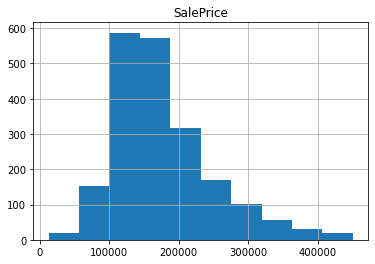

In [5]:
#checking distribution of sale price
train.hist(column = ['SalePrice'],bins = 10)

In [6]:
#getting all numeric columns
numeric_cols = train._get_numeric_data().columns

In [7]:
#checking correlations of all columns to sale price
corrs = pd.DataFrame(train.corr()['SalePrice'])
corrs

,SalePrice
Id,-0.044784
PID,-0.242965
MS SubClass,-0.074766
Lot Frontage,0.339715
Lot Area,0.274632
Overall Qual,0.804390
Overall Cond,-0.089854
Year Built,0.596201
Year Remod/Add,0.567764
Mas Vnr Area,0.458498


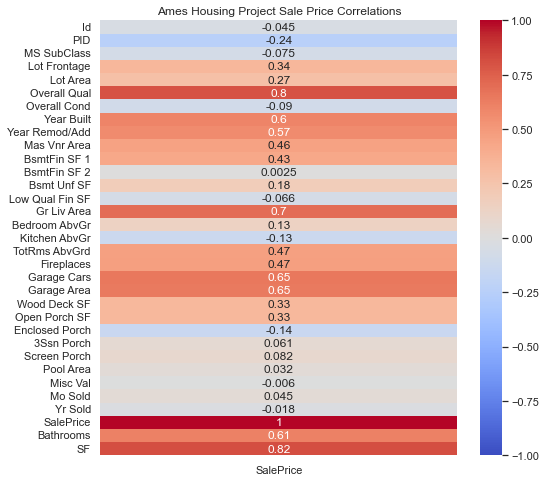

In [8]:
#heatmap for the correlation between all columns and sale price
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(train.corr()[['SalePrice']], vmin = -1, annot = True, cmap = 'coolwarm')
plt.title('Ames Housing Project Sale Price Correlations');
plt.savefig('../images/correlations.jpg');

In [9]:
#making dummies for columns i'm interested in
obj_cols = [each for each in train.columns if each not in numeric_cols]
problem_cols = ['Neighborhood', 'Condition 1', 'Condition 2', 'MS Zoning']
train_dummies = pd.get_dummies(train, columns=problem_cols)
test_dummies = pd.get_dummies(test, columns=problem_cols)
missing_from_test = [col for col in train_dummies.columns if col not in test_dummies.columns]
test_dummies[missing_from_test] = 0
train_dummies.head(3)

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,109,533352170,60,69.0552,13517,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0
1,544,531379050,60,43.0000,11492,Pave,NA,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0
2,153,535304180,20,68.0000,7922,Pave,NA,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,0,1,0


In [10]:
#getting higher correlation columns
higher_corrs = corrs[corrs.values > .6].index
higher_corrs

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'SalePrice', 'Bathrooms', 'SF'],
      dtype='object')

In [12]:
#looking at the non numeric columns
train[obj_cols]

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type
0,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,...,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
1,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,...,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD
2,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,NA,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,...,NA,BuiltIn,Fin,TA,TA,Y,NA,NA,NA,WD
4,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,...,NA,Detchd,Unf,TA,TA,N,NA,NA,NA,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,RL,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Gd,Attchd,Fin,TA,TA,Y,NA,NA,NA,WD
2020,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,NA,Detchd,Unf,TA,TA,Y,NA,NA,NA,WD
2021,RL,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,Crawfor,Norm,...,TA,Detchd,Unf,Fa,Fa,Y,NA,NA,NA,WD
2022,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Gd,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD


In [13]:
#using one hot encoder on the columns i'm interested in
ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(train[problem_cols])

train_ohe = pd.DataFrame(
    ohe.transform(train[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

train_ohe.head(3)

,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,...,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
#checking the numeric columns 
train._get_numeric_data().columns

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'Bathrooms',
       'SF'],
      dtype='object')

In [15]:
#combining one hot encoder data with the rest of the data
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

full_train = pd.concat([train, train_ohe], axis = 1)
full_test = pd.concat([test, test_ohe], axis = 1)

num_cols = higher_corrs.drop(['SalePrice', 'Bathrooms'])
features = list(num_cols) + problem_cols

In [16]:
#setting up for the models
X = train[features]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')
ohe.fit(X_train[problem_cols])

#convert  training problem columns
X_train_ohe = pd.DataFrame (
    ohe.transform(X_train[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

X_test_ohe = pd.DataFrame (
    ohe.transform(X_test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [17]:
#combining train and test data with one hot encoder
X_train_full = pd.concat([X_train.reset_index(drop = True), X_train_ohe], axis = 1).drop(columns = problem_cols)
X_test_full = pd.concat([X_test.reset_index(drop=True), X_test_ohe], axis = 1).drop(columns = problem_cols)

In [18]:
#making a pipeline and getting score with lasso
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LassoCV(verbose = True))
])

pipe.fit(X_train_full, y_train)
pipe.score(X_train_full, y_train), pipe.score(X_test_full, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


(0.8591471580811091, 0.8460857976443166)

In [19]:
#checking error
rmse(pipe, X_train_full, y_train), rmse(pipe, X_test_full, y_test)

(26043.72004876768, 29472.48349625824)

In [20]:
#transforming one hot encoder data
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [21]:
#combining test features with one hot encoder and filling out nulls with 0
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)

In [22]:
#predictions
preds = pipe.predict(test_subset)

In [23]:
#getting coef values for lasso
lasso_coefs = pipe.named_steps['lr'].coef_
coef_df = pd.DataFrame(lasso_coefs, index = X_train_full.columns, columns = ['coef val'])
coef_df.sort_values(by='coef val')

,coef val
MS Zoning_RM,-3927.952014
Neighborhood_OldTown,-2912.754759
Neighborhood_SWISU,-2158.870028
Condition 1_Artery,-2046.296157
Neighborhood_NAmes,-1994.456057
Neighborhood_NPkVill,-1769.467694
Neighborhood_NWAmes,-1734.124044
Neighborhood_Edwards,-1584.485220
Neighborhood_BrDale,-1326.205794
Neighborhood_IDOTRR,-1226.842128


In [24]:
sum(coef_df['coef val'] == 0)

6

In [25]:
#combining one hot encoder data with the rest of the data
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)
preds = pipe.predict(test_subset)

In [26]:
#getting predictions for sale price
preds = pd.DataFrame(
    pipe.predict(test_subset),
    columns = ['SalePrice']
)
preds = pd.concat([pd.DataFrame(test.Id, columns = ['Id']), preds], axis = 1)

In [27]:
#saving lasso predictions to a csv
preds.to_csv('../datasets/submission_lasso.csv', index_label = False, index = False, columns = preds.columns)

---------------------

In [28]:
#making pipeline and getting score for ridge
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', RidgeCV())
])

pipe.fit(X_train_full, y_train)
pipe.score(X_train_full, y_train), pipe.score(X_test_full, y_test)

(0.8593660940838479, 0.8451166850685465)

In [29]:
#checking error
rmse(pipe, X_train_full, y_train), rmse(pipe, X_test_full, y_test)

(26023.471520892414, 29565.12385994028)

In [30]:
#transforming one hot encoder data
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)

In [31]:
#combining test features with one hot encoder and filling out nulls with 0
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)

In [32]:
#getting predictions
preds = pipe.predict(test_subset)

In [33]:
#getting coef values for lasso
ridge_coefs = pipe.named_steps['lr'].coef_
coef_df = pd.DataFrame(ridge_coefs, index = X_train_full.columns, columns = ['coef val'])
coef_df.sort_values(by='coef val')

,coef val
Neighborhood_OldTown,-4040.205618
Neighborhood_NAmes,-3354.777559
Neighborhood_SWISU,-2781.328483
Neighborhood_Edwards,-2611.826691
MS Zoning_RM,-2605.094555
Neighborhood_NWAmes,-2522.390607
Neighborhood_NPkVill,-2178.883395
Neighborhood_IDOTRR,-2056.725744
Condition 1_Artery,-1956.199323
Neighborhood_BrDale,-1847.082726


In [34]:
sum(coef_df['coef val'] == 0)

0

In [35]:
#combining one hot encoder data with the rest of the data
test_ohe = pd.DataFrame(
    ohe.transform(test[problem_cols]),
    columns = ohe.get_feature_names(problem_cols)
)
test_subset = pd.concat([test[features].drop(columns = problem_cols), test_ohe], axis = 1).fillna(0)
preds = pipe.predict(test_subset)

In [36]:
#getting sale price predictions for ridge
preds = pd.DataFrame(
    pipe.predict(test_subset),
    columns = ['SalePrice']
)
preds = pd.concat([pd.DataFrame(test.Id, columns = ['Id']), preds], axis = 1)

In [37]:
#putting the coefs together
rid = pd.DataFrame(ridge_coefs, index = X_train_full.columns, columns=['ridge'])
las = pd.DataFrame(lasso_coefs, index = X_train_full.columns, columns=['lasso'])
pd.concat([rid, las])

,ridge,lasso
Overall Qual,22101.962224,NaN
Gr Liv Area,6236.589793,NaN
Garage Cars,696.648769,NaN
Garage Area,8870.440599,NaN
SF,23004.277488,NaN
...,...,...
MS Zoning_FV,NaN,640.047641
MS Zoning_I (all),NaN,583.767420
MS Zoning_RH,NaN,195.115457
MS Zoning_RL,NaN,0.000000


In [39]:
#saving ridge predictions to a csv
preds.to_csv('../datasets/submission_ridge.csv', index_label = False, index = False, columns = preds.columns)